In [4]:
import os

import matplotlib.pyplot as plt
import tiktoken
import torch
import torch.nn as nn

cwd = os.getcwd()
# Go up two levels (from 'gpt_from_scratch' to 'ideas' to 'project_root')
project_root = os.path.abspath(os.path.join(cwd, "..", ".."))
os.chdir(project_root)

from ideas.gpt_from_scratch.model import (
    DummyGPTModel,
    LayerNorm,
    GELU,
    FeedForward,
    ExampleDeepNeuralNetwork,
    TransformerBlock,
    GPTModel,
)
from ideas.gpt_from_scratch.config import GPT_CONFIG_124M

## Tokenizer

In [5]:
tokenizer = tiktoken.get_encoding("gpt2")
batch = []
txt1 = "Every effort moves you"
txt2 = "Evety day holds a "

In [6]:
batch.append(torch.tensor(tokenizer.encode(txt1)))
# batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch)
print(batch)

tensor([[6109, 3626, 6100,  345]])


## Dummy Model

In [7]:
torch.manual_seed(42)
model = DummyGPTModel(GPT_CONFIG_124M)

In [8]:
logits = model(batch)
print("Output shape:", logits.shape)
print(logits)

Output shape: torch.Size([1, 4, 50257])
tensor([[[ 0.1597,  0.1958, -0.1044,  ...,  0.0555,  0.4726, -0.5874],
         [-0.7750,  0.5466, -1.2552,  ..., -0.2906,  0.1688,  0.4970],
         [-0.9552, -1.1343,  0.4898,  ..., -0.0489, -0.2273,  0.1706],
         [ 1.3697, -0.8169, -0.2184,  ...,  0.9854,  0.4593,  0.6592]]],
       grad_fn=<UnsafeViewBackward0>)


In [9]:
torch.manual_seed(42)
batch_example = torch.randn(2, 5)
layer = nn.Sequential(nn.Linear(5, 6), nn.ReLU())
out = layer(batch_example)
print(out)

tensor([[0.0000, 0.1842, 0.0052, 0.7233, 0.0000, 0.5298],
        [0.0000, 0.0000, 0.0000, 0.2237, 0.0000, 0.7727]],
       grad_fn=<ReluBackward0>)


In [10]:
mean = out.mean(dim=-1, keepdim=True)
var = out.var(dim=-1, keepdim=True)
print("Mean:", mean)
print("Variance:", var)

Mean: tensor([[0.2404],
        [0.1661]], grad_fn=<MeanBackward1>)
Variance: tensor([[0.0982],
        [0.0963]], grad_fn=<VarBackward0>)


In [11]:
# let's apply layer norm
out_norm = (out - mean) / torch.sqrt(var)
mean = out_norm.mean(dim=-1, keepdim=True)
var = out_norm.var(dim=-1, keepdim=True)
torch.set_printoptions(sci_mode=False)
print("After LayerNorm:\n", out_norm)
print("Mean", mean)
print("Variance", var)

After LayerNorm:
 tensor([[-0.7672, -0.1794, -0.7506,  1.5410, -0.7672,  0.9234],
        [-0.5351, -0.5351, -0.5351,  0.1857, -0.5351,  1.9546]],
       grad_fn=<DivBackward0>)
Mean tensor([[    0.0000],
        [    0.0000]], grad_fn=<MeanBackward1>)
Variance tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


In [12]:
ln = LayerNorm(emb_dim=5)
out_ln = ln(batch_example)

# let's verify that our LayerNorm works as expected
mean = out_ln.mean(dim=-1, keepdim=True)
var = out_ln.var(dim=-1, keepdim=True, unbiased=False)
print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[    -0.0000],
        [     0.0000]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


## GELU vs ReLU

In [13]:
gelu, relu = GELU(), nn.ReLU()

In [14]:
x = torch.linspace(-3, 3, steps=100)

In [15]:
y_gelu, y_relu = gelu(x), relu(x)

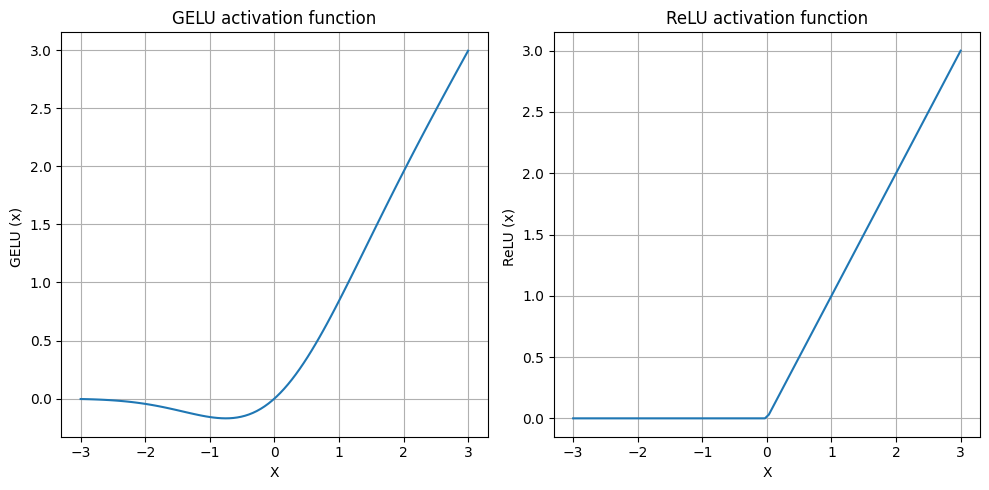

In [16]:
plt.figure(figsize=(10, 5))
for i, (y, label) in enumerate(zip([y_gelu, y_relu], ["GELU", "ReLU"]), 1):
    plt.subplot(1, 2, i)
    plt.plot(x, y)
    plt.title(f"{label} activation function")
    plt.xlabel("X")
    plt.ylabel(f"{label} (x) ")
    plt.grid(True)
plt.tight_layout()
plt.show()

In [17]:
ffn = FeedForward(GPT_CONFIG_124M)
x = torch.rand(2, 3, 768)
out = ffn(x)
print(out.shape)

torch.Size([2, 3, 768])


## With vs Without Shortcut (Residual) Connections

In [18]:
layer_sizes = [3, 3, 3, 3, 3, 1]
sample_input = torch.tensor([[1.0, 0.0, -1.0]])
torch.manual_seed(42)
model_wo_shortcut = ExampleDeepNeuralNetwork(layer_sizes, use_shortcut=False)

In [19]:
def print_gradients(model, x):
    output = model(x)
    target = torch.tensor([[0.0]])

    loss = nn.MSELoss()
    loss = loss(output, target)

    loss.backward()

    for name, param in model.named_parameters():
        if "weight" in name:
            print(f"{name} has gradient mean of {param.grad.abs().mean().item()}")

In [20]:
print_gradients(model_wo_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.00012918967695441097
layers.1.0.weight has gradient mean of 0.0001873663713922724
layers.2.0.weight has gradient mean of 0.00031841068994253874
layers.3.0.weight has gradient mean of 0.00215659337118268
layers.4.0.weight has gradient mean of 0.006823497358709574


In [21]:
torch.manual_seed(42)
model_with_shortcut = ExampleDeepNeuralNetwork(layer_sizes, use_shortcut=True)

In [22]:
print_gradients(model_with_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.0023823725059628487
layers.1.0.weight has gradient mean of 0.004156599752604961
layers.2.0.weight has gradient mean of 0.0032569176983088255
layers.3.0.weight has gradient mean of 0.003522999119013548
layers.4.0.weight has gradient mean of 0.011212223209440708


In [23]:
torch.manual_seed(42)
x = torch.rand(2, 4, 768)
block = TransformerBlock(GPT_CONFIG_124M)
output = block(x)

print("Input shape:", x.shape)
print("Output shape:", output.shape)

Input shape: torch.Size([2, 4, 768])
Output shape: torch.Size([2, 4, 768])


## Full Model

In [24]:
torch.manual_seed(42)
model = GPTModel(GPT_CONFIG_124M)

In [26]:
out = model(batch)
print("Input batch:\n", batch)
print("Output shape:", out.shape)
print(out)

Input batch:
 tensor([[6109, 3626, 6100,  345]])
Output shape: torch.Size([1, 4, 50257])
tensor([[[-0.2624, -0.4071, -0.0777,  ...,  0.2087, -0.3317,  0.8778],
         [ 0.1817, -1.0874,  0.3159,  ...,  0.0026,  0.4131, -0.0120],
         [-0.7925, -0.4138, -0.1475,  ...,  0.4292, -0.2339, -1.0747],
         [ 0.2028,  0.3273, -0.6728,  ..., -0.2816, -0.8086,  0.6918]]],
       grad_fn=<UnsafeViewBackward0>)


In [29]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters in the model: {total_params:,}")

Total number of parameters in the model: 163,037,184


In [30]:
print("Token embedding layer shape:", model.tok_emb.weight.shape)
print("Output layer shape:", model.out_head.weight.shape)

Token embedding layer shape: torch.Size([50257, 768])
Output layer shape: torch.Size([50257, 768])


In [31]:
total_params_gpt2 = total_params - sum(p.numel() for p in model.out_head.parameters())
print(
    f"Number of trainable parameters "
    f"considering weight tying: {total_params_gpt2:,}"
)

Number of trainable parameters considering weight tying: 124,439,808


In [32]:
total_size_bytes = total_params * 4
total_size_mb = total_size_bytes / (1024**2)
print(f"Total size of the model: {total_size_mb:.2f} MB")

Total size of the model: 621.94 MB


## Showtime

In [33]:
def generate_text_sample(model, idx, max_new_tokens, context_size):
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)

        logits = logits[:, -1, :]
        probas = torch.softmax(logits, dim=-1)
        idx_next = torch.argmax(probas, dim=-1, keepdim=True)
        idx = torch.cat((idx, idx_next), dim=1)

    return idx

In [35]:
start_context = "Hello, I am"
encoded = tokenizer.encode(start_context)
print("Encoded input:", encoded)
encoded_tensor = torch.tensor(encoded).unsqueeze(0)
print("encoded_tensor.shape:", encoded_tensor.shape)

Encoded input: [15496, 11, 314, 716]
encoded_tensor.shape: torch.Size([1, 4])


In [36]:
model.eval()
out = generate_text_sample(
    model=model,
    idx=encoded_tensor,
    max_new_tokens=6,
    context_size=GPT_CONFIG_124M["context_length"],
)

print("Output:", out)
print("Output length:", out.shape[0])

Output: tensor([[15496,    11,   314,   716,  8727, 40976, 19063, 23111, 46174, 24977]])
Output length: 1


In [38]:
decoded_text = tokenizer.decode(out.squeeze(0).tolist())
print(decoded_text)

Hello, I amwhocoded backgroundspherd Elise 1949
